![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller, podrá poner en práctica sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller, se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles, puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Importación de librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier

### Datos préstamo de bicicletas

In [2]:
# Lectura de la información del archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv',
                    index_col = 'datetime',
                    parse_dates = True)

# Renombrar la variable *count* a *total*
bikes.rename(columns = {'count':'total'}, inplace = True)

# Crear la hora como una variable
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados, realice un análisis descriptivo sobre las variables *season* y *hour*, y escriba sus inferencias sobre los datos. Para complementar su análisis, puede usar métricas como máximo, mínimo, percentiles entre otros.

In [3]:
# Celda 1.1
season_bikes = round(bikes.groupby('season').total.mean())
df_season = pd.DataFrame(season_bikes)
display(df_season)
print(f'El valor mínimo es: {season_bikes.min()} {df_season[df_season["total"] == season_bikes.min()].index.values}')
print(f'El valor máximo es: {season_bikes.max()} {df_season[df_season["total"] == season_bikes.max()].index.values}')
print(f'La media es: {season_bikes.mean()}')
print(f'La mediana es: {season_bikes.median()}')
print(f'El percentil 75 es: {season_bikes.quantile(0.75)}')

,total
season,
1,116.0
2,215.0
3,234.0
4,199.0


El valor mínimo es: 116.0 [1]
El valor máximo es: 234.0 [3]
La media es: 191.0
La mediana es: 207.0
El percentil 75 es: 219.75


El resultado anterior, permite observar que la temporada de verano (3) fue la época donde más se rentaron bicicletas entre el 2011 y el 2012 con una media de 234 bicicletas por hora; mientras que el invierno (1) fue la época con el valor más bajo con 116 bicicletas alquiladas por hora en promedio. Adicionalmente, la media, la mediana y el percentil del 75% fueron 191, 207 y 220, respectivamente.

In [4]:
# Celda 1.2
hour_bikes = round(bikes.groupby('hour').total.mean())
df_hour = pd.DataFrame(hour_bikes)
display(df_hour)
print(f'El valor mínimo es: {hour_bikes.min()} {df_hour[df_hour["total"] == hour_bikes.min()].index.values}')
print(f'El valor máximo es: {hour_bikes.max()} {df_hour[df_hour["total"] == hour_bikes.max()].index.values}')
print(f'La media es: {hour_bikes.mean()}')
print(f'La mediana es: {hour_bikes.median()}')
print(f'El percentil 75 es: {hour_bikes.quantile(0.75)}')

,total
hour,
0,55.0
1,34.0
2,23.0
3,12.0
4,6.0
5,20.0
6,76.0
7,213.0
8,363.0


El valor mínimo es: 6.0 [4]
El valor máximo es: 469.0 [17]
La media es: 190.79166666666666
La mediana es: 212.0
El percentil 75 es: 257.25


De acuerdo al resultado obtenido, se logra apreciar que la hora en la que más se rentaron bicicletas entre el 2011 y el 2012 fue a las 05:00 pm con un valor promedio de 469. Por otro lado, la hora en la que menos se alquilaron fue a las 04:00 am con una media de 6 bicicletas. Por otro lado, la media, la mediana y el percentil del 75% fueron 191, 212 y 257, respectivamente.

### Punto 2 - Análisis de gráficos

Primero, ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3, escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable *hour* (hora) cuando la variable *season* es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

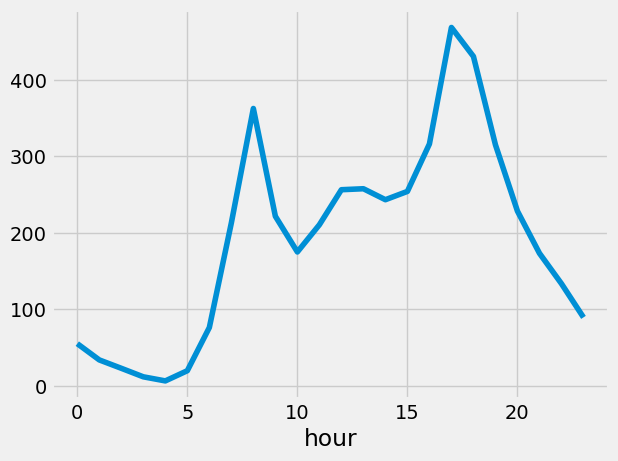

In [5]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
plt.style.use('fivethirtyeight')
bikes.groupby('hour').total.mean().plot()

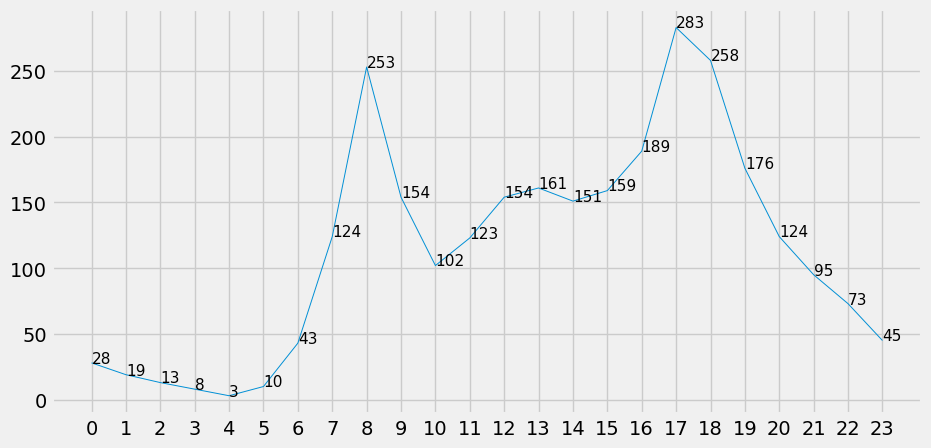

In [6]:
season_inv = round(bikes[bikes['season'] == 1].groupby(['hour']).total.mean().reset_index())
plt.figure(figsize = (10, 5))
plt.plot(season_inv['hour'], season_inv['total'], linewidth = 0.7)
plt.xticks(season_inv['hour'])
for i, j in zip(season_inv['hour'], season_inv['total']): 
    plt.text(i, j, str(int(j)), fontsize = 11)

En el gráfico anterior, se puede observar el número promedio de bicicletas que fueron rentadas por hora en la época de invierno entre el 2011 y el 2012, donde se alcanza a apreciar que durante las primeras horas del día este número fue bajo y muestra un punto de inflexión a partir de las 04:00 am, donde se evidencia una tendencia ascendente hasta las 08:00 am, que fue la tercera hora del día con mayor número de bicicletas rentadas con una media de 253, solo siendo superada por los horarios de las 05:00 pm y 06:00 pm con valores promedios de 283 y 258, respectivamente. A partir de esta última hora, empezó a presentarse una tendencia descendente en la renta de bicicletas.

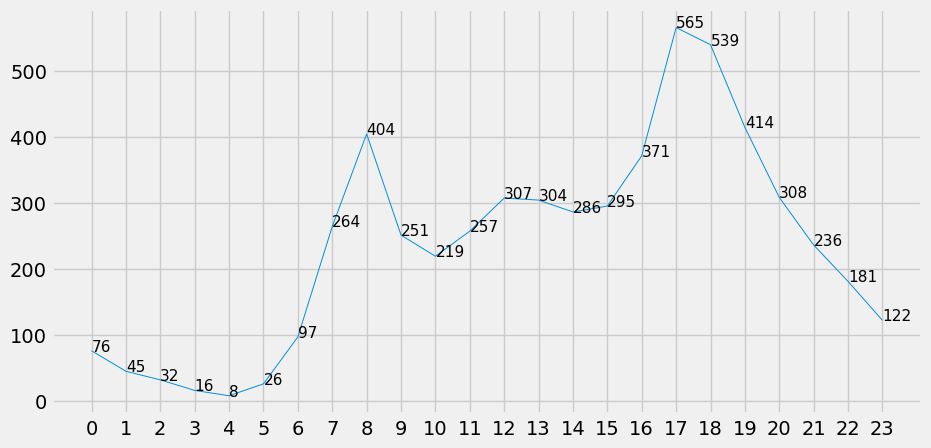

In [7]:
# Celda 2.3 - "season" = 3. Escriba su código y hallazgos
season_ver = round(bikes[bikes['season'] == 3].groupby(['hour']).total.mean().reset_index())
plt.figure(figsize = (10, 5))
plt.plot(season_ver['hour'], season_ver['total'], linewidth = 0.7)
plt.xticks(season_ver['hour'])
for i, j in zip(season_ver['hour'], season_ver['total']): 
    plt.text(i, j, str(int(j)), fontsize = 11)

Este gráfico, el cual muestra la media de las bicicletas que fueron alquiladas cada hora entre el 2011 y el 2012 durante la época de verano, evidencia un comportamiento muy similar al que se presentó en el gráfico anterior, en donde al inicio del día el número promedio de bicicletas que fueron rentadas estuvo bajo y se observa un punto de inflexión a las 04:00 am mostrando un tendencia positiva hasta las 08:00 am. Adicionalmente, los horarios de las 05:00 pm y 06:00 pm registraron el mayor número de alquiler de bicicletas en promedio con valores de 565 y 539, respectivamente, y, a partir de ese momento, este valor empezó su descenso.

Al observar los tres gráficos anteriores, se puede observar que, la distribución de los datos de alquiler de bicicletas entre el 2011 y el 2012, sea teniendo en cuenta todas las estaciones del año o segmentando por la época de invierno o de verano, es muy similar.

### Punto 3 - Regresión lineal
En la celda 3, ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando *total* como variable de respuesta y *season* y *hour* como las únicas variables predictoras, teniendo en cuenta que la variable *season* es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [8]:
# Celda 3

# Definición de las variables predictoras y de la variable de respuesta. Se transforma la variable season en dummy
X = bikes.loc[:, ['season', 'hour']]
X = pd.get_dummies(X, columns = ['season'], drop_first = True)
y = bikes.loc[:, 'total']

# Separación de las variables predictoras y de la variable de respuesta en un conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Implementación y ajuste del modelo de regresión con las datos de entrenamiento
reg_lineal = LinearRegression().fit(X_train, y_train)

# Obtención de los coeficientes del modelo de regresión previamente ajustado
llaves = list(X_train.columns)
valores = list(np.round(reg_lineal.coef_))
print(dict(zip(llaves, valores)))

# Evaluación del error de predicción, utilizando el RMSE, de las observaciones del conjunto de prueba
print(f'\nEl RMSE del modelo de regresión es de {round(np.sqrt(mean_squared_error(reg_lineal.predict(X_test), y_test)))}')

{'hour': 11.0, 'season_2': 99.0, 'season_3': 116.0, 'season_4': 91.0}

El RMSE del modelo de regresión es de 159


A partir del resultado arrojado, se puede mencionar que por cada hora que va transcurriendo durante el día, el número de bicicletas rentadas aumenta en 11. Adicionalmente, si la época del año es primavera, este valor aumenta en 99; si es verano, en 116; y si es otoño, en 91.

Una limitación de los modelos de regresión lineal es que están sesgados, por lo que son poco flexibles. Adicionalmente, asumen linealidad entre la variable de respuesta y las variables predictoras, de manera que no representan la complejidad de la vida real. También, a diferencia de los árboles de decisión y de cualquier técnica basada en ellos (ensamblajes), se debe transformar las variables predictoras que son categóricas.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [9]:
# Celda 4

# Definición de las variables predictoras y de la variable de respuesta. Se transforma la variable de respuesta en binaria
X = bikes.loc[:, ['season', 'hour']]
y = bikes.loc[:, 'total']
y = (bikes.total > y.median()).astype(int)

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean() ** 2 + (1 - y.mean()) ** 2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~ filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la
# bifurcación del árbol
def best_split(X, y, num_pct = 10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct + 1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level = 0, min_gain = 0.001, max_depth = None, num_pct = 10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred = y.iloc[:1].values[0], y_prob = 0.5, level = level, split = -1, n_samples = 1, gain = 0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace
    
    tree = dict(y_pred = y_pred, y_prob = y_prob, level = level, split = -1, n_samples = X.shape[0], gain = gain)
    
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~ filter_l], y.loc[~ filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain = min_gain, max_depth = max_depth, num_pct = num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain = min_gain, max_depth = max_depth, num_pct = num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree = tree_grow(X, y, level = 0, min_gain = 0.001, max_depth = 6, num_pct = 10)

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba = False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~ filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continúa con el derecho 
            predicted[~ filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continúa con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [10]:
tree

{'y_pred': 0,
 'y_prob': 0.49917340191036,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 0.16178755449047394,
 'sl': {'y_pred': 0,
  'y_prob': 0.0942714126807564,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 0.06425451863089747,
  'sl': {'y_pred': 0,
   'y_prob': 0.026106335561922954,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 0.0027878761479700337,
   'sl': {'y_pred': 0,
    'y_prob': 0.010796723752792257,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 0.0008089140964271449},
   'sr': {'y_pred': 0,
    'y_prob': 0.11816192560175055,
    'level': 3,
    'split': [0, 3.0],
    'n_samples': 455,
    'gain': 0.009214309359181827,
    'sl': {'y_pred': 0,
     'y_prob': 0.05240174672489083,
     'level': 4,
     'split': [0, 2.0],
     'n_samples': 227,
     'gain': 0.004655188204359839,
     'sl': {'y_pred': 0,
      'y_prob': 0.008695652173913044,
      'level': 5,
      'split': -1,
      'n_samples': 1

El anterior árbol, se construyó con un máximo de produndidad igual que 6 (*max_depth* = 6), en donde, por ejemplo, para la primera partición la observación tuvo un valor menor al punto de corte, al igual que en la segunda y tercera partición.

In [11]:
# Ejecución de función tree_predict
print(tree_predict(X, tree))
np.unique(tree_predict(X, tree), return_counts = True)

[0. 0. 0. ... 1. 0. 0.]


(array([0., 1.]), array([5073, 5813], dtype=int64))

El anterior arrojado, permite observar las predicciones que se realizaron con el árbol de decisión que se contruyó de forma manual, en donde se logra apreciar que, del total de datos predichos, 5073 mostraron que el número de bicicletas rentadas por hora es inferior o igual que la mediana de bicicletas alquiladas por cada hora, que pare este caso es cuando la variable de respuesta es igual que 0.

### Punto 5 - Árbol de decisión con librería
En la celda 5, entrene un árbol de decisión con la librería **sklearn**, usando las variables predictoras *season* y *hour* y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compárelo con el modelo del punto 3.

(0.61, 10)

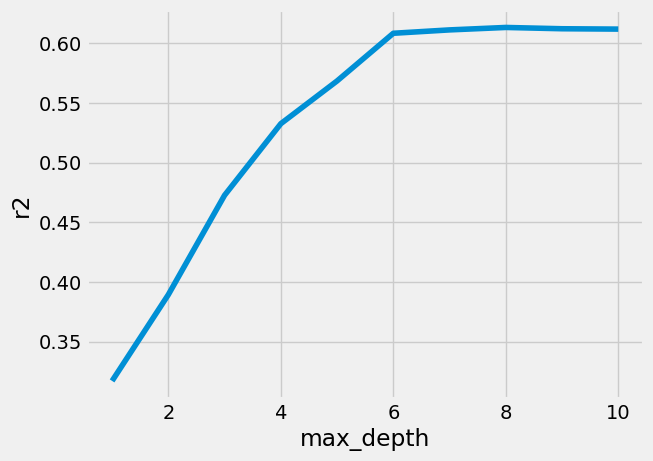

In [12]:
# Celda 5

# Se inicia buscando el criterio de parada de máxima profundidad con el r2 más alto

# Definición de las variables predictoras y de la variable de respuesta
X = bikes.loc[:, ['season', 'hour']]
y = bikes.loc[:, 'total']

# Separación de las variables predictoras y de la variable de respuesta en un conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 11)

# Lista para guardar los valores del r2 para cada valor de máxima profundidad
r2_scores = []

# Bucle para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    tree_reg = DecisionTreeRegressor(max_depth = depth, random_state = 1)
    r2_scores.append(cross_val_score(tree_reg, X_train, y_train, cv = 10, scoring = 'r2').mean())

# Gráfica max_depth versus r2
plt.plot(max_depth_range, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')

# Mejor r2 (desempeño del modelo) y su correspondiente max_depth
sorted(zip(np.round(r2_scores, 2), max_depth_range))[-1]

In [13]:
# max_depth = 10 fue el mejor, se ajusta un árbol usando este valor 
tree_reg = DecisionTreeRegressor(max_depth = 10, random_state = 1).fit(X_train, y_train)

# Evaluación del error de predicción de las observaciones del set de test
round(np.sqrt(mean_squared_error(tree_reg.predict(X_test), y_test)))

117

Se puede observar que el *RMSE* del modelo de árboles de decisión estableciendo una máxima profundidad de 10 es igual que 117, por lo que dicho modelo tiene un mejor desempeño al de regresión lineal ya que el error fue menor (la métrica de desempeño de este último modelo fue de 159).

## Parte B - Métodos de ensamblajes
En esta parte del taller, se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles, puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [14]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [15]:
df.drop(['url', 'Popular'], axis = 1)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,2.0,...,0.470000,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8
1,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,0.0,...,0.342778,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1
2,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,0.0,...,0.516263,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0
3,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,0.0,...,0.436654,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0
4,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,0.0,...,0.346429,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,523.0,10.0,660.0,0.493884,1.0,0.633971,20.0,4.0,1.0,0.0,...,0.311531,0.050000,0.50,-0.258730,-0.80,-0.100000,0.1,0.0,0.4,0.0
5996,139.0,9.0,144.0,0.647887,1.0,0.739583,15.0,4.0,10.0,1.0,...,0.287273,0.100000,0.60,-0.250000,-0.30,-0.200000,0.0,0.0,0.5,0.0
5997,623.0,8.0,536.0,0.512287,1.0,0.647929,6.0,2.0,1.0,1.0,...,0.304167,0.100000,0.40,-0.156250,-0.30,-0.100000,0.0,0.0,0.5,0.0
5998,584.0,10.0,266.0,0.534413,1.0,0.605882,9.0,6.0,1.0,0.0,...,0.304924,0.100000,0.60,-0.250000,-0.40,-0.100000,0.0,0.0,0.5,0.0


In [16]:
# Definición variable de interés y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [17]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6, construya un árbol de decisión y una regresión logística. Para el árbol, calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [18]:
# Celda 6

# Se ajusta el modelo de regresión logística con los datos de entrenamiento
reg_log = LogisticRegression().fit(X_train, y_train)

# Evaluación del desempeño con las métricas Accuracy y F1-Score
print(round(metrics.accuracy_score(reg_log.predict(X_test), y_test), 2),
      round(metrics.f1_score(reg_log.predict(X_test), y_test), 2))

0.61 0.61


Accuracy: (0.63, 2)

F1-Score: (0.63, 2)


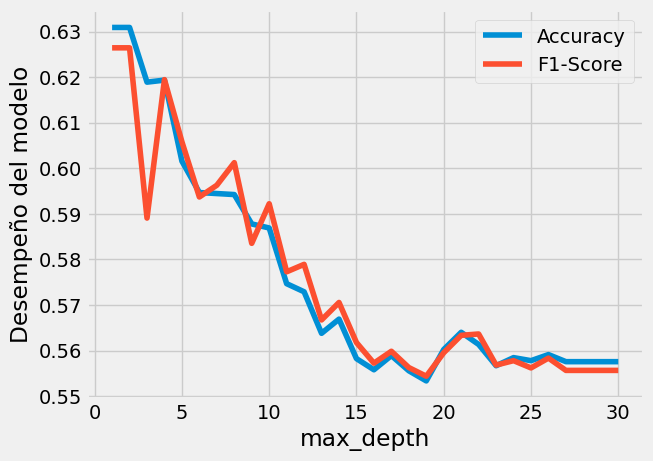

In [19]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 31)

# Lista para guardar los valores del Accuracy para cada valor de máxima profundidad
accuracy_scores = []

# Bucle para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf_tree = DecisionTreeClassifier(max_depth = depth, random_state = 1)
    accuracy_scores.append(cross_val_score(clf_tree, X_train, y_train, cv = 10, scoring = 'accuracy').mean())

# Lista para guardar los valores del F1-Score para cada valor de máxima profundidad
f1_scores = []

# Bucle para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf_tree = DecisionTreeClassifier(max_depth = depth, random_state = 1)
    f1_scores.append(cross_val_score(clf_tree, X_train, y_train, cv = 10, scoring = 'f1').mean())

# Gráfica max_depth versus Accuracy and F1-Score (desempeño del modelo)
plt.plot(max_depth_range, accuracy_scores, label = 'Accuracy')
plt.plot(max_depth_range, f1_scores, label = 'F1-Score')
plt.xlabel('max_depth')
plt.ylabel('Desempeño del modelo')
plt.legend()

# Mejor Accuracy y F1-Score (desempeño del modelo) y su correspondiente max_depth
print(f'Accuracy: {sorted(zip(np.round(accuracy_scores, 2), max_depth_range))[-1]}')
print(f'\nF1-Score: {sorted(zip(np.round(f1_scores, 2), max_depth_range))[-1]}')

El resultado anterior, muestra que el *Accuracy* y el *F1-Score* coincidieron en el criterio de parada de máxima profundidad que tiene mejor desempeño, el cual es igual que 2. Por lo tanto, modelo de clasificación de árboles de decisión se calibrará con un *max_depth* = 2.

In [20]:
clf_tree = DecisionTreeClassifier(max_depth = 2, random_state = 1).fit(X_train, y_train)
print(round(metrics.accuracy_score(clf_tree.predict(X_test), y_test), 2),
      round(metrics.f1_score(clf_tree.predict(X_test), y_test), 2))

0.65 0.64


Al comparar el *Accuracy* y el *F1-Score* de los modelos de regresión logística y árboles de decisión con una profundidad máxima de 2, se pudo obtener que el último modelo alcanzó los valores más altos en ambas métricas con valores de 0.65 y 0.64, respectivamente, frente a 0.61 en cada métrica para el modelo de regresión logística. Por lo tanto, el modelo de árboles de decisión fue el que mostró el mayor desempeño.

### Punto 7 - Votación Mayoritaria
En la celda 7, elabore un esamble con la metodología de **Votación Mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde *max_depth* tome un valor de su elección\
-100 árboles de decisión donde *min_samples_leaf* tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados.

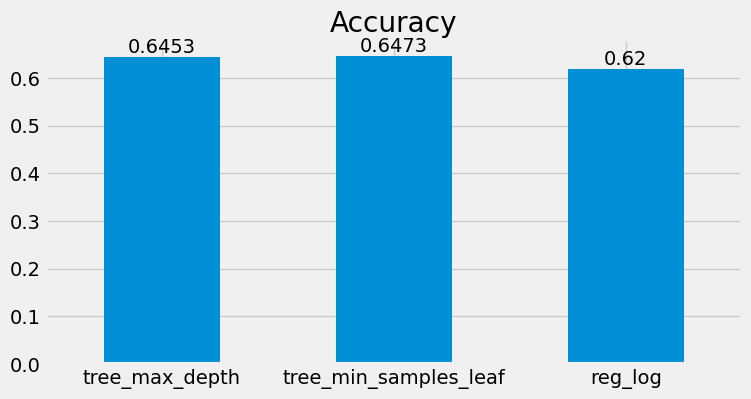

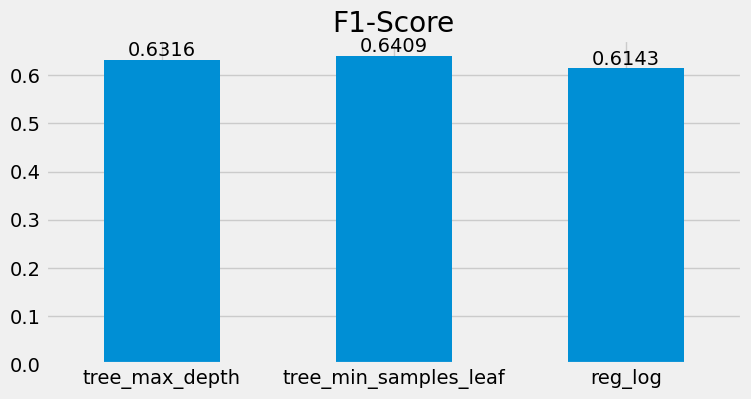

In [21]:
# Celda 7

# Se ajusta un modelo de clasificación compuesto por 300 muestras bagged con 100 árboles de decisión y un max_depth
# igual que 2
clf_bag1 = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2),
                             n_estimators = 100,
                             bootstrap = True,
                             random_state = 42,
                             n_jobs = -1,
                             oob_score = True,
                             max_samples = 300).fit(X_train, y_train)

# Se ajusta un modelo de clasificación compuesto por 300 muestras bagged con 100 árboles de decisión y un
# min_samples_split igual que 100
clf_bag2 = BaggingClassifier(base_estimator = DecisionTreeClassifier(min_samples_leaf = 100),
                             n_estimators = 100,
                             bootstrap = True,
                             random_state = 42,
                             n_jobs = -1,
                             oob_score = True,
                             max_samples = 300).fit(X_train, y_train)

# Se ajusta un modelo de clasificación compuesto por 300 muestras bagged con 100 regresiones logísticas
clf_bag3 = BaggingClassifier(base_estimator = LogisticRegression(),
                             n_estimators = 100,
                             bootstrap = True,
                             random_state = 42,
                             n_jobs = -1,
                             oob_score = True,
                             max_samples = 300).fit(X_train, y_train)

# Evaluación del desempeño de los tres escenarios anteriores con la métrica Accuracy
acc_tree_max_depth = round(metrics.accuracy_score(clf_bag1.predict(X_test), y_test), 4)
acc_tree_min_samples_leaf = round(metrics.accuracy_score(clf_bag2.predict(X_test), y_test), 4)
acc_reg_log = round(metrics.accuracy_score(clf_bag3.predict(X_test), y_test), 4)

# Evaluación del desempeño de los tres escenarios anteriores con la métrica F1-Score
f1_score_tree_max_depth = round(metrics.f1_score(clf_bag1.predict(X_test), y_test), 4)
f1_score_tree_min_samples_leaf = round(metrics.f1_score(clf_bag2.predict(X_test), y_test), 4)
f1_score_reg_log = round(metrics.f1_score(clf_bag3.predict(X_test), y_test), 4)

# Se grafica el Accuracy de los tres escenarios
df1_acc = pd.DataFrame([['tree_max_depth', acc_tree_max_depth],
                       ['tree_min_samples_leaf', acc_tree_min_samples_leaf],
                       ['reg_log', acc_reg_log]],
                      columns = ['Escenario', 'Accuracy'])
ax1_acc = df1_acc.plot.bar(x = 'Escenario',
                           y = 'Accuracy',
                           rot = 0,
                           figsize = (8, 4),
                           legend = False,
                           xlabel = '',
                           title = 'Accuracy')
for container in ax1_acc.containers:
    ax1_acc.bar_label(container)

# Se gráfica el F1-Score de los tres escenarios
df1_f1_score = pd.DataFrame([['tree_max_depth', f1_score_tree_max_depth],
                            ['tree_min_samples_leaf', f1_score_tree_min_samples_leaf],
                            ['reg_log', f1_score_reg_log]],
                           columns = ['Escenario', 'F1-Score'])
ax1_f1_score = df1_f1_score.plot.bar(x = 'Escenario',
                                     y = 'F1-Score',
                                     rot = 0,
                                     figsize = (8, 4),
                                     legend = False,
                                     xlabel = '',
                                     title = 'F1-Score')
for container in ax1_f1_score.containers:
    ax1_f1_score.bar_label(container)

Al observar las gráficas anteriores, se logra apreciar que el escenario 2, que es un modelo de clasificación compuesto por 300 muestras bagged con 100 árboles de decisión y un *min_samples_split* igual que 100 no solamente es el que muestra el mayor Accuracy sino también el F1-Score más alto, con valores de 0.6473 y 0.6409, respectivamente, lo que lo convierte en el modelo con el mejor desempeño de los tres.

### Punto 8 - Votación Ponderada
En la celda 8, elabore un ensamble con la metodología de **Votación Ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

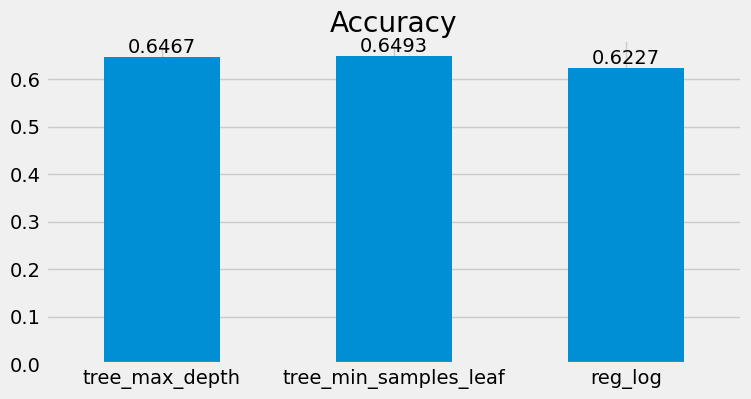

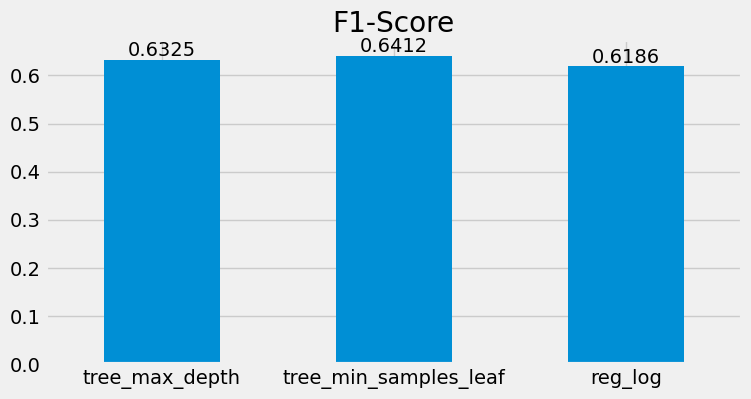

In [22]:
# Celda 8

# Lista de los modelos de clasificación bagging con los tres escenarios
lista_clf_bag = [clf_bag1, clf_bag2, clf_bag3]

# Listas donde se almacenarán las métricas Accuracy y F1-Score de los modelos de clasificación bagging con los tres escenarios 
lista_acc = []
lista_f1_score = []

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
for i in lista_clf_bag:
    errors = np.zeros(i.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], i.n_estimators))

    for j in range(i.n_estimators):
        oob_sample = ~ i.estimators_samples_[j]
        y_pred_ = i.estimators_[j].predict(X_train.values[oob_sample])
        errors[j] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, j] = i.estimators_[j].predict(X_test)

    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis = 1) >= 0.5).astype(np.int)
    
    lista_acc.append(round(metrics.accuracy_score(y_pred, y_test), 4))
    lista_f1_score.append(round(metrics.f1_score(y_pred, y_test), 4))

# Se grafica el Accuracy de los tres escenarios
df2_acc = pd.DataFrame({'Escenario':['tree_max_depth', 'tree_min_samples_leaf', 'reg_log'], 'Accuracy':lista_acc})
ax2_acc = df2_acc.plot.bar(x = 'Escenario',
                           y = 'Accuracy',
                           rot = 0,
                           figsize = (8, 4),
                           legend = False,
                           xlabel = '',
                           title = 'Accuracy')
for container in ax2_acc.containers:
    ax2_acc.bar_label(container)

# Se gráfica el F1-Score de los tres escenarios
df2_f1_score = pd.DataFrame({'Escenario':['tree_max_depth', 'tree_min_samples_leaf', 'reg_log'], 'F1-Score':lista_f1_score})
ax2_f1_score = df2_f1_score.plot.bar(x = 'Escenario',
                                     y = 'F1-Score',
                                     rot = 0,
                                     figsize = (8, 4),
                                     legend = False,
                                     xlabel = '',
                                     title = 'F1-Score')
for container in ax2_f1_score.containers:
    ax2_f1_score.bar_label(container)

El resultado anterior, permite observar que el escenario 2, que es un modelo de clasificación compuesto por 300 muestras bagged con 100 árboles de decisión y un *min_samples_split* igual que 100 no solamente es el que muestra el mayor Accuracy sino también el F1-Score más alto, con valores de 0.6493 y 0.6412, respectivamente, conviertiéndose de esta manera en el modelo con el mejor desempeño en comparación con los otros dos.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

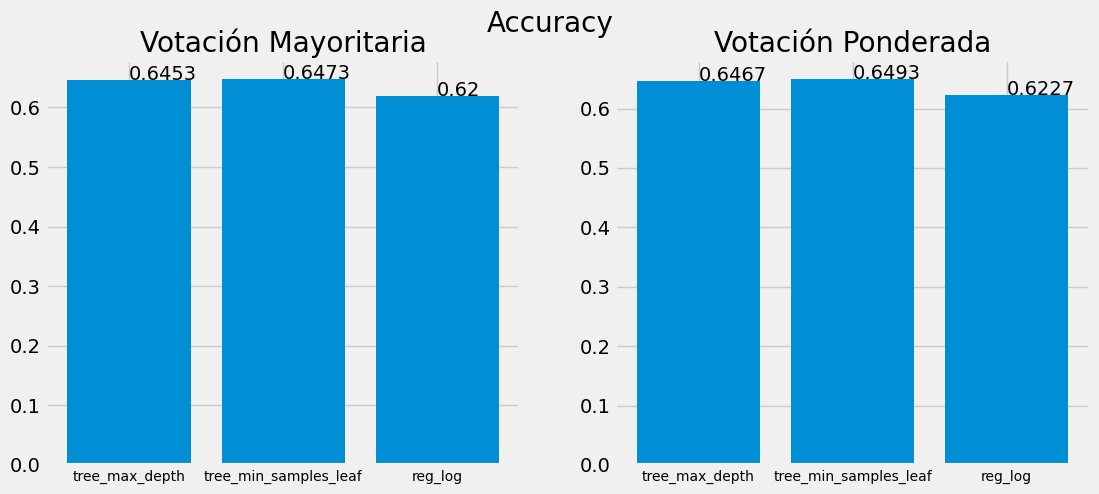

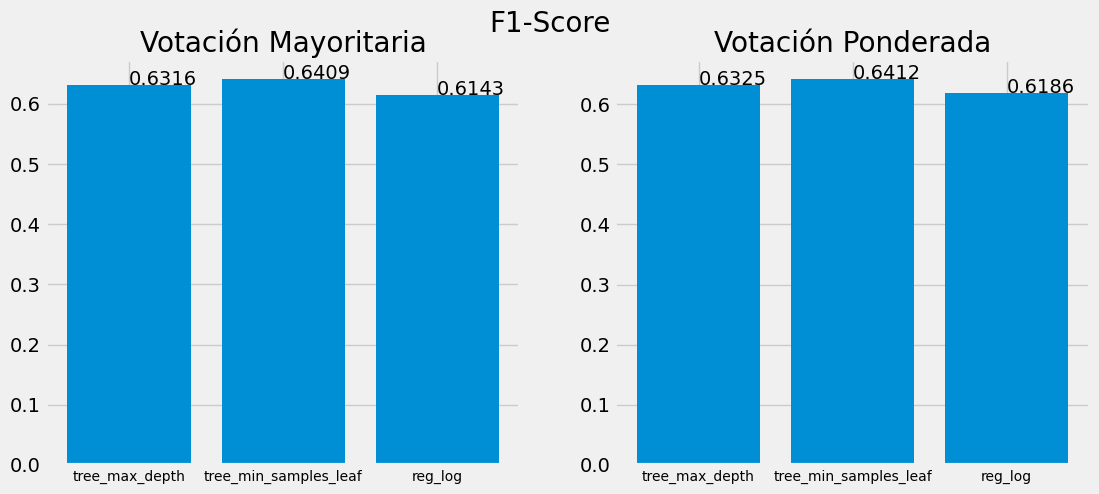

In [23]:
# Celda 9

fig1, (ax1_acc, ax2_acc) = plt.subplots(1, 2, figsize = (12, 5))
fig1.suptitle('Accuracy', fontsize = 20)

ax1_acc.bar(df1_acc.Escenario, df1_acc.Accuracy)
ax1_acc.set_xticklabels(df1_acc.Escenario, fontsize = 10)
ax1_acc.title.set_text("Votación Mayoritaria")
for i in range(len(df1_acc.Escenario)):
    ax1_acc.text(df1_acc.Escenario[i], df1_acc.Accuracy[i], df1_acc.Accuracy[i])

ax2_acc.bar(df2_acc.Escenario, df2_acc.Accuracy)
ax2_acc.set_xticklabels(df2_acc.Escenario, fontsize = 10)
ax2_acc.title.set_text("Votación Ponderada")
for i in range(len(df2_acc.Escenario)):
    ax2_acc.text(df2_acc.Escenario[i], df2_acc.Accuracy[i], df2_acc.Accuracy[i])

fig2, (ax1_f1, ax2_f1) = plt.subplots(1, 2, figsize = (12, 5))
fig2.suptitle('F1-Score', fontsize = 20)

ax1_f1.bar(df1_f1_score.Escenario, df1_f1_score['F1-Score'])
ax1_f1.set_xticklabels(df1_f1_score.Escenario, fontsize = 10)
ax1_f1.title.set_text("Votación Mayoritaria")
for i in range(len(df1_f1_score.Escenario)):
    ax1_f1.text(df1_f1_score.Escenario[i], df1_f1_score['F1-Score'][i], df1_f1_score['F1-Score'][i])

ax2_f1.bar(df2_f1_score.Escenario, df2_f1_score['F1-Score'])
ax2_f1.set_xticklabels(df2_f1_score.Escenario, fontsize = 10)
ax2_f1.title.set_text("Votación Ponderada")
for i in range(len(df2_f1_score.Escenario)):
    ax2_f1.text(df2_acc.Escenario[i], df2_f1_score['F1-Score'][i], df2_f1_score['F1-Score'][i])

De acuerdo a los gráficos anteriores, se puede observar que los tres escenarios de la metodología de *Votación Ponderada* mostraron un *Accuracy* y un *F1-Score* levemente mejor a los de la metodología de *Votación Mayoritaria*.

Una ventaja de estas dos metodologías es que reduce el sobreajuste, por lo que lo convierte en un modelo de aprendizaje supervisado preciso. Adicionalmente, se puede utilizar para problemas de regresión y clasificación, y los valores faltantes no afectan el resultado del modelo. Una desventaja es que puede ser computacionalmente ineficiente dependiendo del número de modelos que se quieran entrenar.